In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
from matplotlib.finance import fetch_historical_yahoo, parse_yahoo_historical_ochl
# import mpl_finance
# from mpl_finance import fetch_historical_yahoo, parse_yahoo_historical_och

rcParams['figure.figsize'] = 15, 5

C:\Users\msharp\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\backends\__init__.py:89: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  (name, backend_version))
C:\Users\msharp\AppData\Local\Continuum\anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\__init__.py:356: MatplotlibDeprecationWarning: matplotlib.verbose is deprecated;
Command line argument --verbose-LEVEL is deprecated.
This functionality is now provided by the standard
python logging library.  To get more (or less) logging output:
    import logging
    logger = logging.getLogger('matplotlib')
    logger.set_level(logging.INFO)
  @cbook.deprecated("2.1")


In [8]:
import os
os.environ["https_proxy"] = 'http://proxy-web.micron.com:80'
os.environ["http_proxy"] = 'http://proxy-web.micron.com:80'

fh = fetch_historical_yahoo('^GSPC', (2016, 1, 1), (2016, 12, 31))
yahoo_data = parse_yahoo_historical_ochl(fh, asobject=True, adjusted=False)
# after much investigation looks like yahoo API is discontinued sometime around May 2017
# this book was published sometime 2017 (probably earlier)

HTTPError: HTTP Error 502: Bad Gateway

In [ ]:
dates = [x[0] for x in list(yahoo_data)]
values = [x[-1] for x in list(yahoo_data)]
data = pd.DataFrame({'Close_Adj':values}, index=dates)

date_thresh = datetime.strptime('2016-10-01',"%Y-%m-%d").date()

data_train = data[:date_thresh]
data_test = data[date_thresh:]

plt.plot(data_train.index, data['Close_Adj'])
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Yahoo Adjusted closing rate - Year 2016')

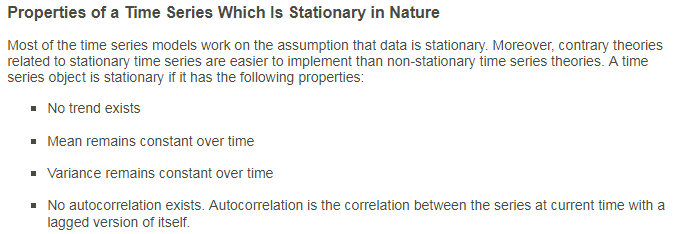

In [ ]:
def evaluate_stationarity(timeseries, t=30):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [ ]:
evaluate_stationarity(data_train['Close_Adj'], 15)

In [ ]:
data_log = np.log(data_train['Close_Adj'])
evaluate_stationarity(data_log, 15)

In [ ]:
data_log = np.log(data_train['Close_Adj'])

#Determing rolling statistics
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

#Plot rolling statistics:
orig = plt.plot(data_log, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.ylim([7.4,7.8])
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
data_sqrt = np.sqrt(data_train['Close_Adj'])
evaluate_stationarity(data_sqrt, 15)

In [ ]:
moving_avg = pd.rolling_mean(data_log,15)
plt.plot(data_log)
plt.plot(moving_avg, color='red')

In [ ]:
data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.head(15)

In [ ]:
data_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_log_moving_avg_diff)

In [ ]:
expwighted_avg = pd.ewma(data_log, halflife=15)
data_log_ewma_diff = data_log - expwighted_avg
evaluate_stationarity(data_log_ewma_diff)

In [ ]:
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

In [ ]:
# Excercise: Apply second- and third-order differencing to our log transformed series. Did it make the log transformed series stationary?

In [ ]:
# Decomposition - breaking to trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_log), freq=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

Durbin Watson Statistic
Contrary to the autocorrelation correlogram, Durbin Watson statistic is more of a statistical approach to determining the existence of autocorrelation within the data. It does so by computing autocorrelation among residuals from a statistical regression analysis. It returns a number between 0 and 4 where 0 depicts strong positive autocorrelation, 4 depicts strong negative autocorrelation, and 2 depicts no autocorrelation at all.

In [ ]:
sm.stats.durbin_watson(data_log_diff)

In [ ]:
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

In [ ]:
# ARIMA(p,d,q) - Auto-Regressive Integrated Moving Averages
# AR - Auto-Regressive -> q=0
model = ARIMA(data_log, order=(2, 1, 0), dates=data_log.index.to_datetime())
results_AR_210 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_210.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_210.fittedvalues-data_log_diff)**2))

In [ ]:
# MA - Moving Average -> p=0
model = ARIMA(data_log, order=(0, 1, 1), dates=data_log.index.to_datetime())
results_MA_011 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_MA_011.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_011.fittedvalues-data_log_diff)**2))

In [ ]:
model = ARIMA(data_log, order=(1, 1, 1), dates=data_log.index.to_datetime())
results_ARIMA_111 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_ARIMA_111.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_111.fittedvalues-data_log_diff)**2))

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA_111.fittedvalues,
copy=True)
print predictions_ARIMA_diff.head()

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

In [ ]:
print results_ARIMA_111.aic

In [ ]:
predictions_ARIMA_log = pd.Series(data_log.ix[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_
cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or
    percent error = * 100

def rmse(y, yhat):
    return np.sqrt(sum((yhat-y)**2)/len(y))

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train['Close_Adj'])
plt.plot(predictions_ARIMA)

plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f'% (
        rmse(data_train['Close_Adj'], predictions_ARIMA), mean_forecast_
            err(data_train['Close_Adj'], predictions_ARIMA), mean_absolute_
            err(data_train['Close_Adj'], predictions_ARIMA)))


In [ ]:
regr = LinearRegression()

x_train = [[x] for x in range(len(data_train))]
y_train = [[y] for y in list(data_train['Close_Adj'])]

x_test = [[z] for z in range(x+1, x + 1+len(data_test))]

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

explained_variance_score(data_test['Close_Adj'], y_pred)

plt.scatter(range(len(data_test)), data_test['Close_Adj'], color='black')
plt.plot(range(len(data_test)), y_pred, color='blue',
             linewidth=3)
plt.ylabel('Concrete strength')